# <span style="font-family: Comic Shanns, sans-serif; color:palegreen">Random Forest Intervals</span>

<span style="font-family: Comic Shanns, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

## <span style="font-family: Comic Shanns, sans-serif; color:turquoise">Regression</span>

Random Forests provide various methods to estimate prediction uncertainty. Below are four common approaches:

### 1. **Standard Deviation Method**
Estimate uncertainty via the standard deviation of individual tree predictions:

$$\sigma = \sqrt{\frac{1}{B - 1} \sum_{b=1}^B \left( \hat{f_b} - \hat{f} \right)^2}, \quad \hat{f} = \frac{1}{B} \sum_{b=1}^B \hat{f_b}$$

### 2. **Percentile Method**
A non-parametric approach using percentiles of individual tree predictions:

$$
\text{Lower Bound} = \text{Percentile}_{\alpha/2}\left(\hat{f_1}, \dots, \hat{f_B}\right), \quad
\text{Upper Bound} = \text{Percentile}_{1 - \alpha/2}\left(\hat{f_1}, \dots, \hat{f_B}\right)
$$

### 3. **Out-of-Bag (OOB) Method**
Uses OOB residuals and variances, requiring ground truth:

$$
\text{OOB Residual} = y_i - \hat{f}^{\text{OOB}}_i, \quad
\text{OOB Variance} = \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{f}^{\text{OOB}}_i \right)^2
$$

Uncertainty:

$$
\text{OOB Uncertainty} = \sqrt{\frac{\sum_{b \in \text{OOB Trees}} \left( \hat{f_b} - \hat{f} \right)^2}{\text{Number of OOB Trees} - 1}}
$$

[Source](https://andrewpwheeler.com/2022/02/04/prediction-intervals-for-random-forests/).

### 4. **Bootstrap Method**
A non-parametric approach using bootstrapped predictions:

$$
\text{Bootstrap Prediction} = \hat{f}_b^{\text{Bootstrap}}, \quad
\text{Bootstrap Uncertainty} = \sqrt{\frac{1}{B - 1} \sum_{b=1}^B \left( \hat{f}_b^{\text{Bootstrap}} - \hat{f} \right)^2}
$$

### Synthetic regression data

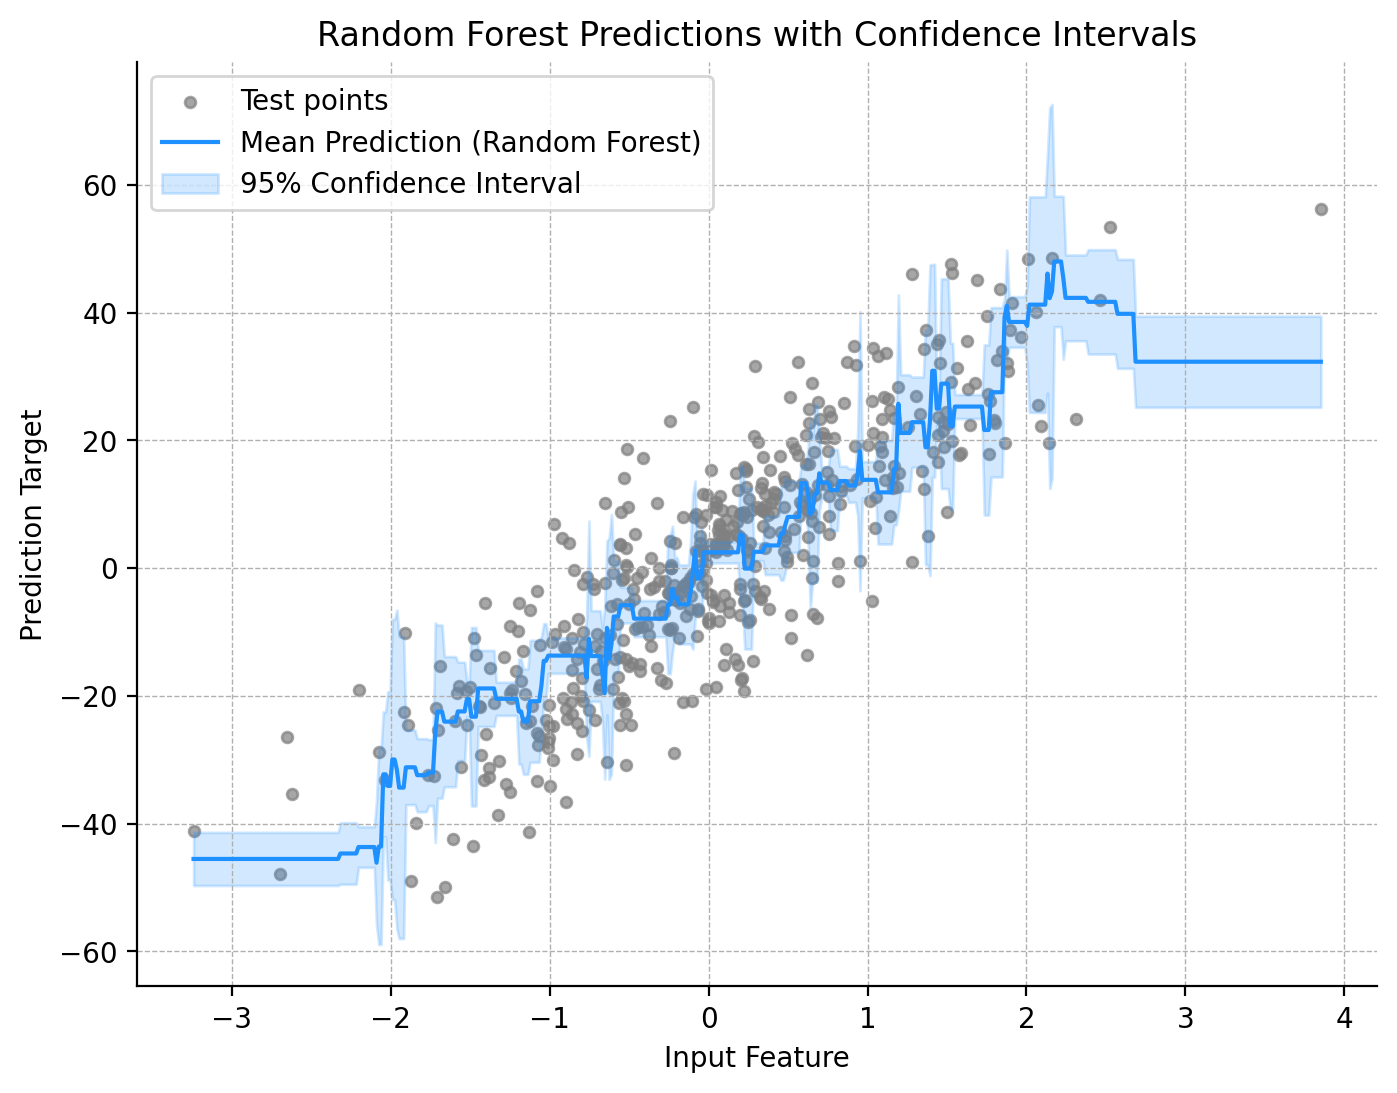

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from scipy.stats import norm
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-bright')

# Generate synthetic data
X, y = make_regression(n_samples=1000, n_features=1, noise=10, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = X[:500], X[500:], y[:500], y[500:]

# Train Random Forest Regressor
rf = RandomForestRegressor(max_depth=5, n_estimators=5, random_state=42)
rf.fit(X_train, y_train)

# Create a smoother test range for predictions
X_test_smooth = np.linspace(X_test.min(), X_test.max(), 500).reshape(-1, 1)

# Get individual tree predictions for the test set
all_tree_predictions = np.array([tree.predict(X_test_smooth) for tree in rf.estimators_])

# Compute mean prediction (ensemble prediction)
mean_prediction = all_tree_predictions.mean(axis=0)
std_dev = all_tree_predictions.std(axis=0, ddof=1)

# Get a z for 95% confidence interval
z = norm.ppf(0.975)

# Plotting the results
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(X_test, y_test, color="grey", label="Test points", s=15, alpha=0.7)
plt.plot(X_test_smooth, mean_prediction, color="dodgerblue", label="Mean Prediction (Random Forest)")
plt.fill_between(
    X_test_smooth.ravel(),
    mean_prediction - z * std_dev,
    mean_prediction + z * std_dev,
    color="dodgerblue",
    alpha=0.2,
    label="95% Confidence Interval"
)
plt.title("Random Forest Predictions with Confidence Intervals")
plt.xlabel("Input Feature")
plt.ylabel("Prediction Target")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.show()

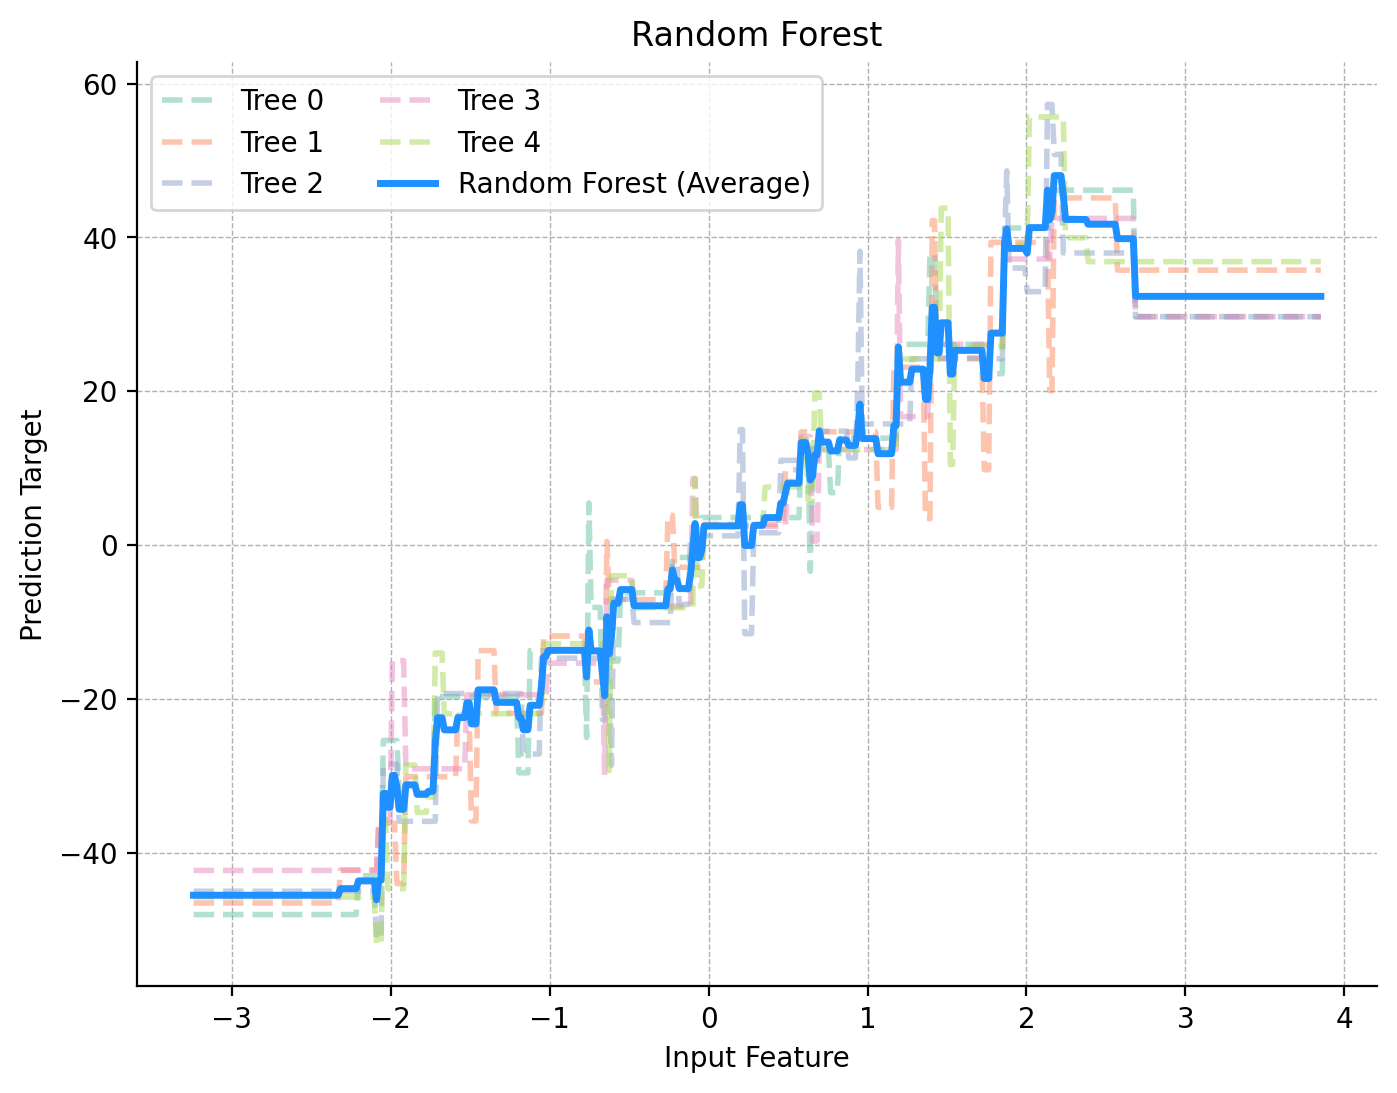

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Define the color palette
colors = plt.get_cmap('Set2')

# Get a z for 95% confidence interval
z = norm.ppf(0.975)

plt.figure(figsize=(8, 6), dpi=100)

# Plot individual tree predictions
bag_predictions = []
for tree_idx, tree in enumerate(rf.estimators_):
    tree_predictions = tree.predict(X_test_smooth)
    plt.plot(
        X_test_smooth,
        tree_predictions,
        linestyle="--",
        label=f"Tree {tree_idx}" if tree_idx < 10 else None,
        alpha=0.5,
        linewidth=2.0,
        color=colors(tree_idx % 10)  # Cycle through colors
    )
    bag_predictions.append(tree_predictions)

# Compute mean prediction
bag_predictions = np.mean(bag_predictions, axis=0)

# Plot Random Forest prediction
plt.plot(
    X_test_smooth.ravel(),
    bag_predictions,
    label="Random Forest (Average)",
    linestyle="-",
    linewidth=2.5,
    color='dodgerblue'
)

# # Plot confidence interval
# plt.fill_between(
#     X_test_smooth.ravel(),
#     bag_predictions - z * std_dev,
#     bag_predictions + z * std_dev,
#     color="dodgerblue",
#     alpha=0.2,
#     label="95% Confidence Interval"
# )

# Scatter plot of test points
# plt.scatter(X_test, y_test, color="grey", label="Test points", s=15, alpha=0.7)

# Improve plot aesthetics
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add legend and title
plt.legend(ncols=2, fontsize=10, frameon=True)
plt.title("Random Forest")
plt.xlabel("Input Feature")
plt.ylabel("Prediction Target")
plt.show()

In [3]:
predictions = rf.predict(X_test)
assert np.allclose(all_tree_predictions.mean(axis=0), bag_predictions)

In [4]:
import pandas as pd
pd.DataFrame(all_tree_predictions).T.corr()

0         1         2         3         4
0  1.000000  0.980957  0.987035  0.988161  0.981358
1  0.980957  1.000000  0.978637  0.983099  0.980456
2  0.987035  0.978637  1.000000  0.985036  0.984267
3  0.988161  0.983099  0.985036  1.000000  0.979853
4  0.981358  0.980456  0.984267  0.979853  1.000000

### Credit Card Balance Data

This dataset comes from [Introduction to Statistical Learning](https://www.statlearning.com/) book.

The response is balance (average credit card debt for each individual) and there are several quantitative predictors: age, cards (number of credit cards), education (years of education), income (in thousands of dollars), limit (credit limit), and rating (credit rating).

[Credit Card Balance Data](https://islp.readthedocs.io/en/latest/datasets/Credit.html#source)

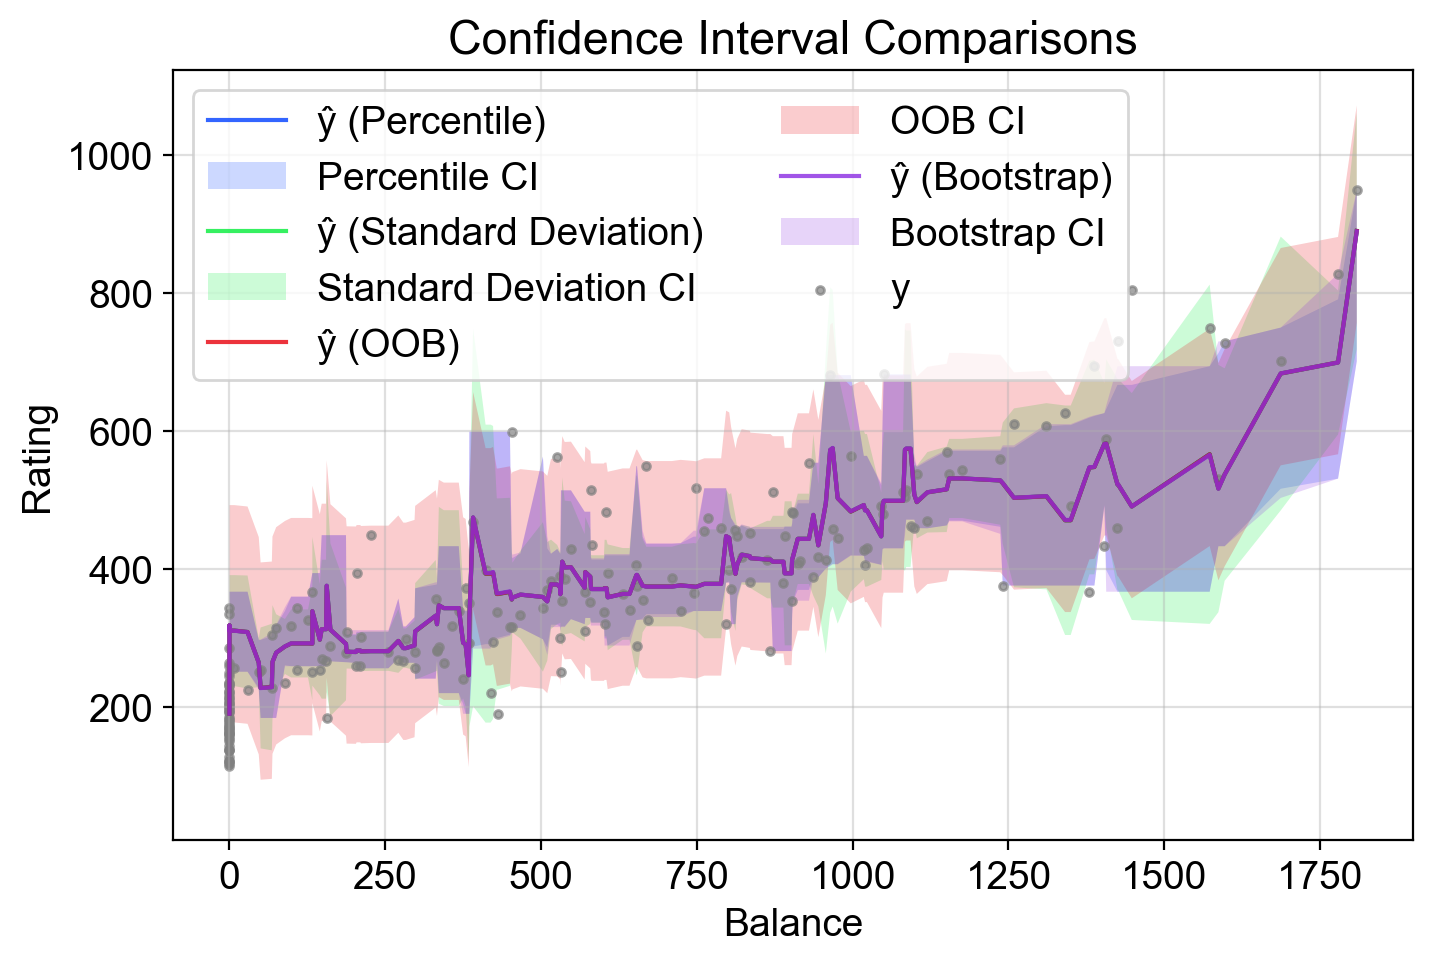

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from ISLP import load_data
%config InlineBackend.figure_format = 'retina'
 
# use style of plt
plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14

Credit = load_data('Credit')

feature_name, target_name = 'Balance', 'Rating'
X, y = Credit[feature_name].values.reshape(-1, 1), Credit[target_name].values
X_train, y_train = X[:200], y[:200]
X_test, y_test = X[200:], y[200:]

rf = RandomForestRegressor(
    max_depth=7,
    n_estimators=100,
    random_state=42,
    oob_score=True,
    min_samples_leaf=1
)
rf.fit(X_train, y_train)

def calculate_coverage(y, lower_bound, upper_bound):
    """
    Calculate the coverage of the prediction intervals.
    """
    return np.mean((y >= lower_bound) & (y <= upper_bound))

# Reusable confidence interval methods
def percentile_confidence_interval(model, X, confidence=0.95):
    """
    Compute confidence intervals using the percentile method.
    """
    tree_predictions = np.array([tree.predict(X) for tree in model.estimators_])
    quantiles = pd.DataFrame(tree_predictions.T).quantile(
        [(1 - confidence) / 2, (1 + confidence) / 2], axis=1
    )
    lower_bound, upper_bound = quantiles.iloc[0], quantiles.iloc[1]
    mean_prediction = tree_predictions.mean(axis=0)

    return mean_prediction, lower_bound.values, upper_bound.values

def std_dev_confidence_interval(model, X, confidence=0.95):
    """
    Compute confidence intervals using the standard deviation method.
    """
    tree_predictions = np.array([tree.predict(X) for tree in model.estimators_])
    mean_prediction = tree_predictions.mean(axis=0)
    std_dev = tree_predictions.std(axis=0)
    z_value = norm.ppf((1 + confidence) / 2)
    lower_bound = mean_prediction - z_value * std_dev
    upper_bound = mean_prediction + z_value * std_dev

    return mean_prediction, lower_bound, upper_bound

def oob_confidence_interval(model, X, y, confidence=0.95):
    """
    Compute confidence intervals using out-of-bag residuals for the Random Forest model.
    From here: https://andrewpwheeler.com/2022/02/04/prediction-intervals-for-random-forests/
    """
    # Compute OOB predictions for the training set
    oob_predictions = model.oob_prediction_

    # Calculate residuals from OOB predictions
    residuals = pd.Series(y - oob_predictions)

    # Compute quantiles of the residual distribution
    lowq = residuals.quantile((1 - confidence) / 2)
    higq = residuals.quantile((1 + confidence) / 2)

    # Generate predictions for the test set
    test_predictions = model.predict(X)

    # Adjust test predictions using residual quantiles
    lower_bound = np.clip(test_predictions + lowq, 0, None)  # Clip to avoid negatives
    upper_bound = test_predictions + higq

    return test_predictions, lower_bound, upper_bound

def bootstrap_prediction_interval(model, X, n_bootstraps=100, confidence=0.95):
    """
    Compute prediction intervals using the bootstrap method for individual predictions.
    """
    all_predictions = []

    for _ in range(n_bootstraps):
        # Sample trees with replacement
        sampled_trees = np.random.choice(model.estimators_, size=len(model.estimators_), replace=True)
        
        # Collect predictions from sampled trees (shape: n_trees, n_samples)
        predictions = np.array([tree.predict(X) for tree in sampled_trees])
        all_predictions.append(predictions.T)  # Transpose so rows correspond to samples

    # Combine predictions from all bootstrap samples (shape: n_samples, n_bootstraps * n_trees)
    all_predictions = np.concatenate(all_predictions, axis=1)

    # Compute prediction intervals
    lower_bound = np.percentile(all_predictions, (1 - confidence) * 100 / 2, axis=1)
    upper_bound = np.percentile(all_predictions, (1 + confidence) * 100 / 2, axis=1)

    # Compute mean prediction
    mean_prediction = all_predictions.mean(axis=1)

    return mean_prediction, lower_bound, upper_bound

# Visualization function
def visualize_intervals(X, y, methods, labels, title="Confidence Interval Comparisons"):
    """
    Plot confidence intervals for different methods.
    """
    plt.figure(figsize=(8, 5))
    
    for method, label in zip(methods, labels):
        mean_prediction, lower_bound, upper_bound = method
        # if label == "Percentile":
        plt.plot(X, mean_prediction, label=f"ŷ ({label})", alpha=0.8)
        plt.fill_between(X.flatten(), lower_bound, upper_bound, alpha=0.2, label=f"{label} CI")
    plt.scatter(X, y, color="grey", label="y", marker="o", s=8, alpha=0.7)
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.title(title)
    plt.legend(ncols=2)
    plt.grid(which="both", alpha=0.4)
    plt.show()

# Sort X_train for plotting
sort_indices = np.argsort(X_train.flatten())
X_train = X_train[sort_indices]
y_train = y_train[sort_indices]

sort_indices = np.argsort(X_test.flatten())
X_test = X_test[sort_indices]
y_test = y_test[sort_indices]

# Generate confidence intervals using different methods
mean_perc, lower_perc, upper_perc = percentile_confidence_interval(rf, X_test)
mean_std, lower_std, upper_std = std_dev_confidence_interval(rf, X_test)

# Find the OOB confidence interval
mean_oob, lower_oob, upper_oob = oob_confidence_interval(rf, X_test, y_test, confidence=0.5)
mean_bs, lower_bs, upper_bs = bootstrap_prediction_interval(rf, X_test, n_bootstraps=1000, confidence=0.95)

# Visualize comparisons
visualize_intervals(
    X_train,
    y_train,
    methods=[
        (mean_perc, lower_perc, upper_perc),
        (mean_std, lower_std, upper_std),
        (mean_oob, lower_oob, upper_oob),
        (mean_bs, lower_bs, upper_bs),
    ],
    labels=[
        "Percentile",
        "Standard Deviation",
        "OOB",
        "Bootstrap"
    ],
)

In [6]:
# Simulate a range of x values
X_simulated = np.linspace(X.min(), X.max() + 500, 1000).reshape(-1, 1)

# Set font to 14
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14

# Generate confidence intervals for simulated range
mean_perc, lower_perc, upper_perc = percentile_confidence_interval(rf, X_simulated)
mean_std, lower_std, upper_std = std_dev_confidence_interval(rf, X_simulated)

# Visualization function with simulated data
def visualize_intervals_simulated(X_sim, y_train, methods, labels, title="Prediction Intervals"):
    """
    Plot confidence intervals for a simulated range of X values.
    """
    plt.figure(figsize=(20, 8), dpi=350)
    
    for method, label in zip(methods, labels):
        mean_prediction, lower_bound, upper_bound = method
        plt.plot(X_sim, mean_prediction, label=f"Mean Prediction ({label})", alpha=0.8, linewidth=4)
        plt.fill_between(X_sim.flatten(), lower_bound, upper_bound, alpha=0.2, label=f"{label} CI")
    plt.scatter(X_train, y_train, color="grey", label="Ground Truth", marker="o", s=20, alpha=0.7)
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    # Disable spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.title(title)
    plt.legend()
    plt.grid(which="both", alpha=0.4)
    plt.show()

# Visualize comparisons with simulated range
visualize_intervals_simulated(
    X_simulated,
    y_train,
    methods=[
        (mean_perc, lower_perc, upper_perc),
        (mean_std, lower_std, upper_std),
    ],
    labels=["Percentile", "Standard Deviation"]
)

### Density Estimation with Random Forests

Here we create density plots for individual trees in the forest.

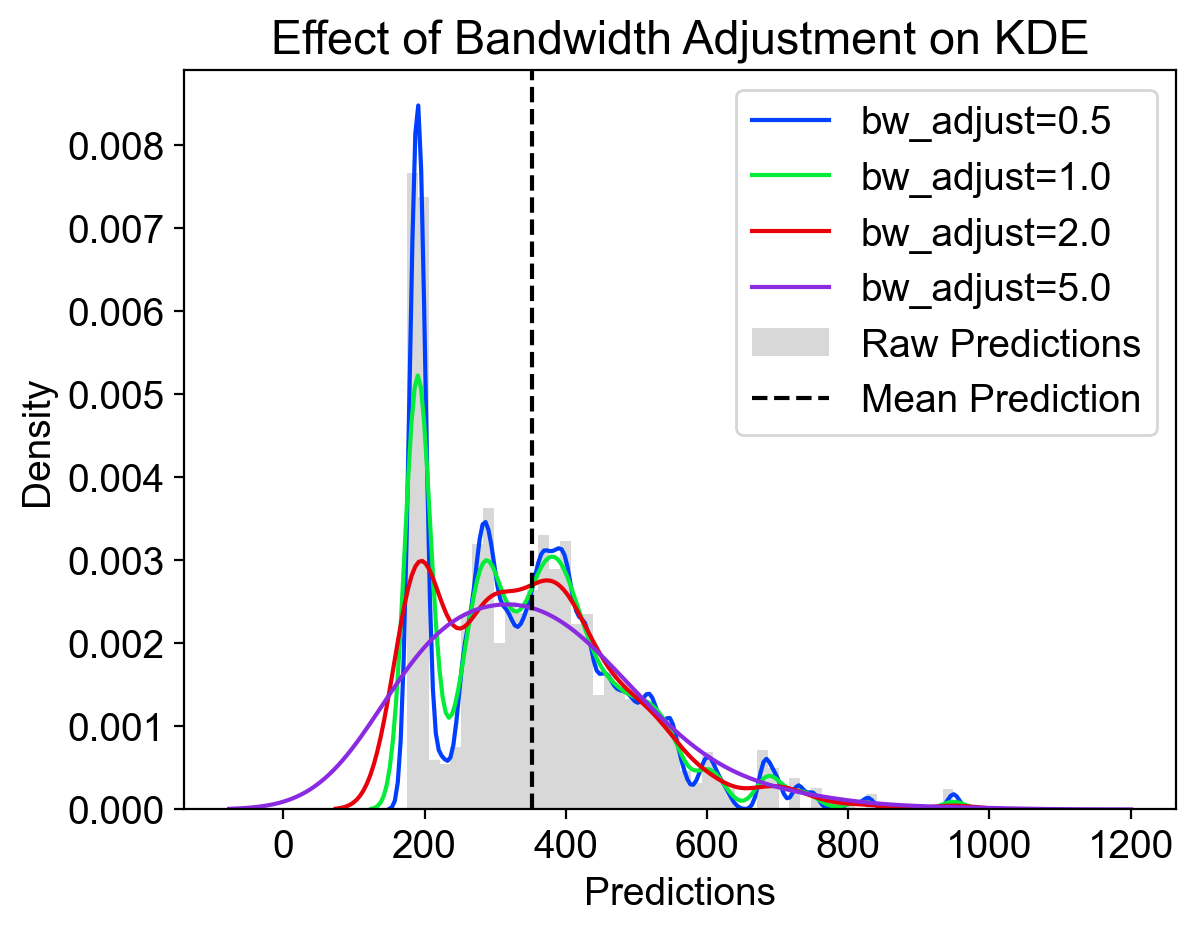

In [7]:
import seaborn as sns

tree_predictions = np.array([tree.predict(X) for tree in rf.estimators_])
df_with_preds = pd.DataFrame(tree_predictions).T

for bw in [0.5, 1.0, 2.0, 5.0]:
    sns.kdeplot(df_with_preds.values.flatten(), bw_adjust=bw, label=f"bw_adjust={bw}")
plt.hist(df_with_preds.values.flatten(), bins=50, alpha=0.3, label="Raw Predictions", color="grey", density=True)
plt.axvline(df_with_preds.values.mean(), color='black', linestyle="--", label="Mean Prediction")
plt.title("Effect of Bandwidth Adjustment on KDE")
plt.xlabel("Predictions")
plt.ylabel("Density")
plt.legend()
plt.show()

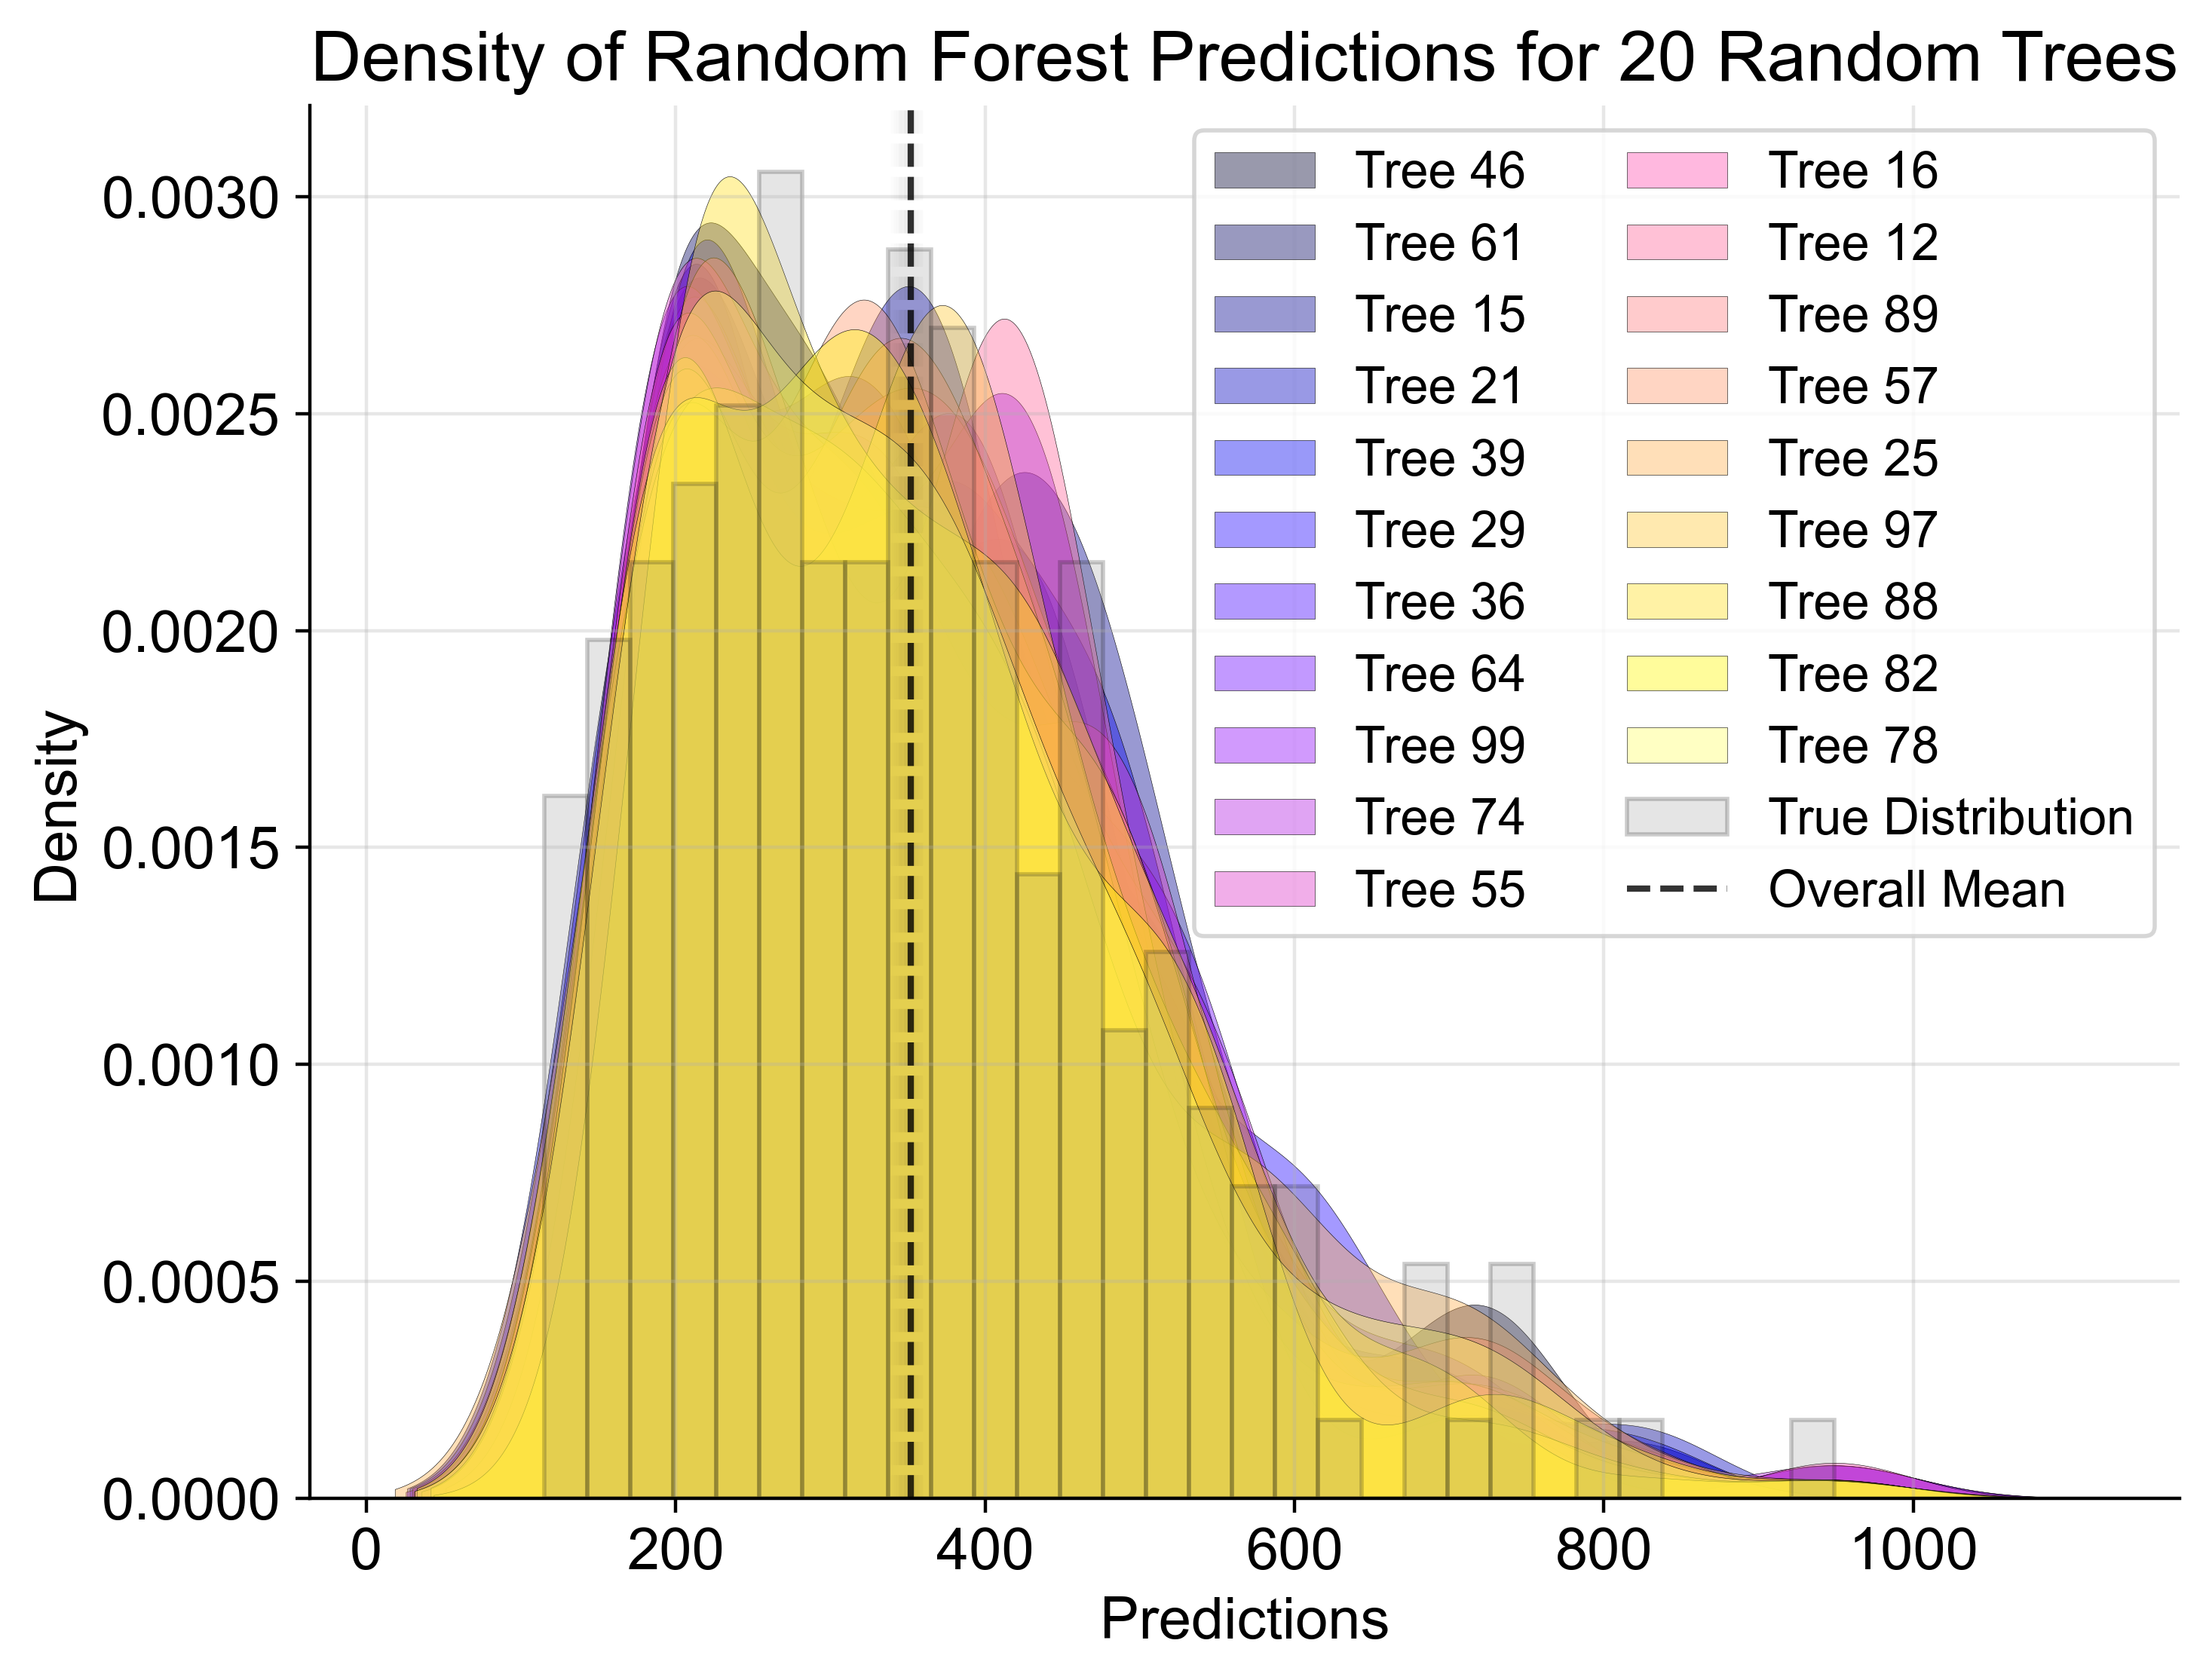

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Set font to Arial
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14

# Randomly sample 20 trees from the estimators
trees_to_sample = 20
sampled_tree_indices = np.random.choice(len(rf.estimators_), size=trees_to_sample, replace=False)

# Collect predictions for the sampled trees
tree_predictions = np.array([rf.estimators_[i].predict(X_train) for i in sampled_tree_indices])
df_with_preds = pd.DataFrame(tree_predictions).T
df_with_preds.columns = [f"Tree_{i}" for i in sampled_tree_indices]

# Plot histograms of the sampled trees
cmapper = sns.color_palette("gnuplot2", trees_to_sample)
plt.figure(figsize=(8, 6), dpi=200)
for i in range(trees_to_sample):
    sns.kdeplot(
        df_with_preds[f"Tree_{sampled_tree_indices[i]}"],
        label=f"Tree {sampled_tree_indices[i]}",
        alpha=0.4,
        color=cmapper[i],
        fill=True,
        bw_adjust=1.0,
        edgecolor='black',
        linewidth=0.1,
        gridsize=1000
    )
    # Plot mean prediction as a vertical line
    plt.axvline(df_with_preds[f"Tree_{sampled_tree_indices[i]}"].mean(), color='black', linestyle="--", alpha=0.01)
plt.hist(y_train, bins=30, color="grey", alpha=0.2, label="True Distribution", density=True, edgecolor='black')
plt.axvline(np.mean(y_train), color='black', linestyle="--", alpha=0.8, label="Overall Mean")
plt.xlabel("Predictions")
plt.ylabel("Density")
plt.title(f"Density of Random Forest Predictions for {trees_to_sample} Random Trees")
plt.legend(ncols=2, fontsize=12)
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(which="major", alpha=0.3)
plt.show()

## <span style="font-family: Comic Shanns, sans-serif; color:aquamarine">Classification</span>

### Bernoulli Confidence Intervals

Using Bernoulli confidence intervals to estimate the uncertainty of the prediction of Random Forest.

$$\text{Confidence Interval} = \hat{p} \pm z \cdot \sqrt{\frac{\hat{p}(1 - \hat{p})}{n_{\text{trees}}}}$$

$$
\begin{align*}
\hat{p} & = \frac{\text{successes}}{n_{\text{trees}}} \quad \text{(Proportion of successes)} \\
z & = \text{Critical value from the standard normal distribution for the desired confidence level (e.g., 1.96 for 95\% confidence)} \\
n_{\text{trees}} & = \text{Number of trees in the random forest.}
\end{align*}
$$

In [9]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
from ISLP import load_data
%config InlineBackend.figure_format = 'retina'
 
# use style of plt
plt.style.use('seaborn-v0_8-bright')

Credit = load_data('Credit')
Credit['Approved'] = Credit['Rating'].apply(lambda x: 1 if x >= 500 else 0)

feature_name, target_name = 'Income', 'Approved'
X, y = Credit[feature_name].values.reshape(-1, 1), Credit[target_name].values

X_train, y_train = X[:200], y[:200]
X_test, y_test = X[200:], y[200:]

rf = RandomForestClassifier(
    max_depth=7,
    n_estimators=100,
    random_state=42,
    min_samples_leaf=1,
    monotonic_cst=[1]
)
rf.fit(X_train, y_train)

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, recall_score,
    precision_score, f1_score, roc_auc_score
)
from rich.console import Console
from rich.table import Table

def classification_metrics(y_true, y_pred):
    """
    Calculate and display classification metrics in a styled table.
    
    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
    """
    # Convert probabilities to binary predictions
    y_pred_clf = (y_pred > 0.5).astype(int)
    # Calculate metrics
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred_clf),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred_clf, adjusted=True),
        "Recall": recall_score(y_true, y_pred_clf),
        "Precision": precision_score(y_true, y_pred_clf),
        "F1 Score": f1_score(y_true, y_pred_clf),
        "Gini": 2 * roc_auc_score(y_true, y_pred) - 1
    }

    # Create a styled table
    table = Table(title="Classification Metrics", title_style="bold cyan1")
    table.add_column("Metric", justify="left", style="cyan1", no_wrap=True)
    table.add_column("Value", justify="right", style="cyan1", no_wrap=True)

    # Add rows to the table
    for metric, value in metrics.items():
        table.add_row(metric, f"{value:.2f}")
    
    # Render the table
    console = Console()
    console.print(table)

predictions = rf.predict_proba(X_test)[:, 1]  # Replace with your model predictions
classification_metrics(y_test, predictions)

   Classification Metrics    
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric            ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Accuracy          │  0.93 │
│ Balanced Accuracy │  0.67 │
│ Recall            │  0.70 │
│ Precision         │  0.85 │
│ F1 Score          │  0.77 │
│ Gini              │  0.94 │
└───────────────────┴───────┘

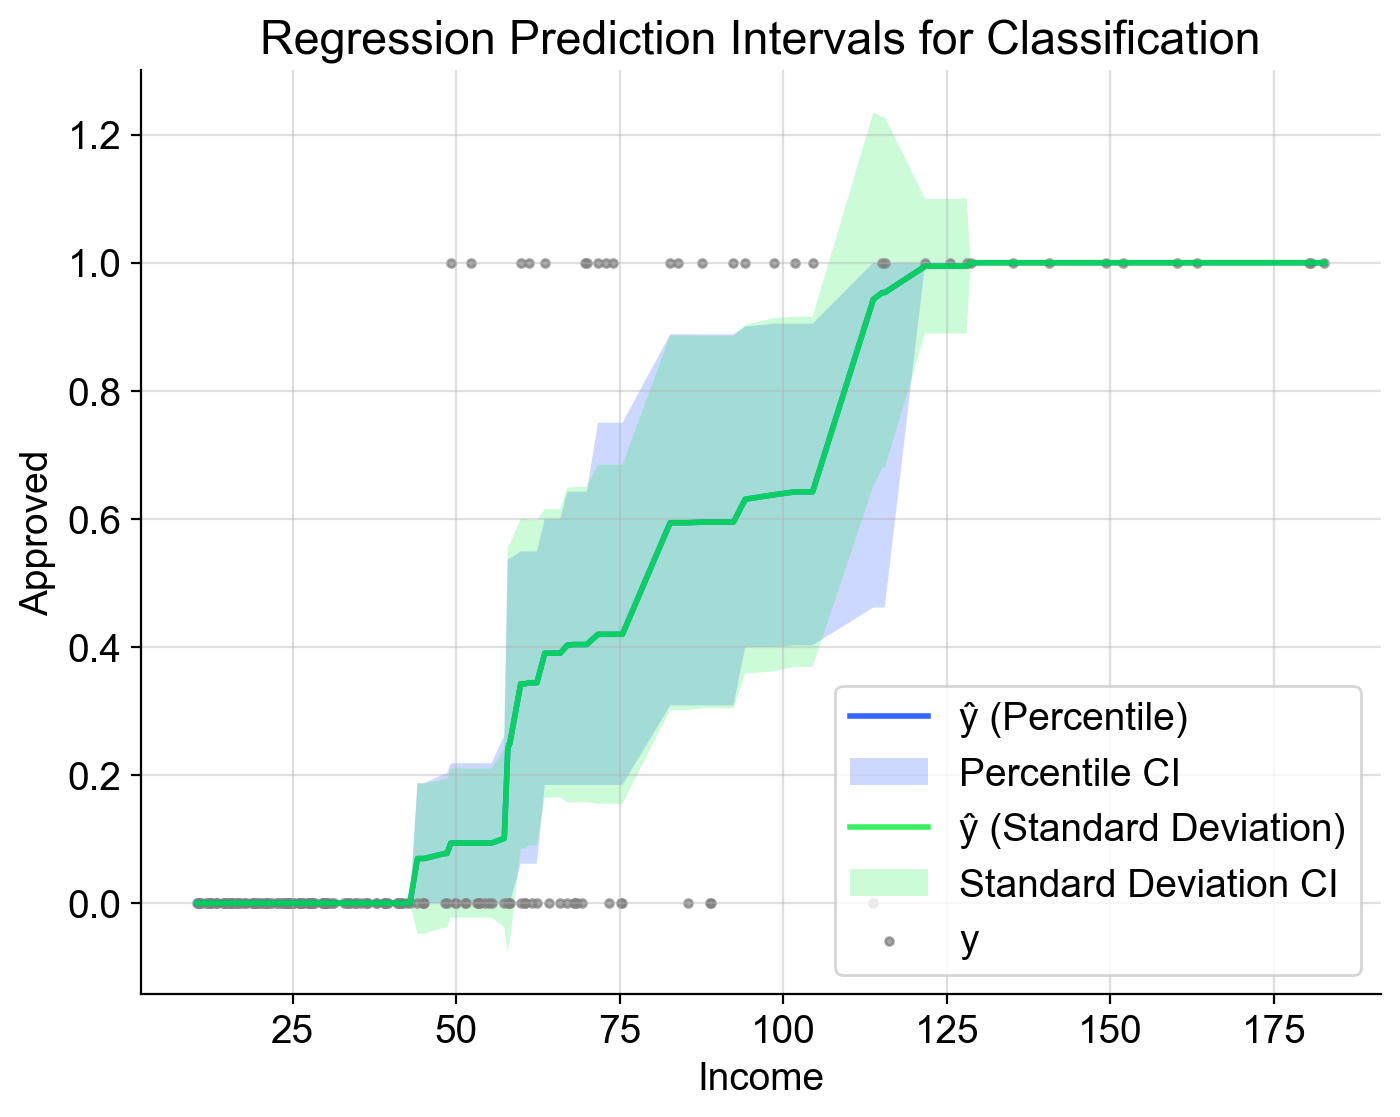

In [10]:
# --- Confidence Intervals for Classification ---

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Reset font size to default
# plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = "Arial"

def calculate_coverage(y, lower_bound, upper_bound):
    """
    Calculate the coverage of the prediction intervals.
    """
    return np.mean((y >= lower_bound) & (y <= upper_bound))

# Reusable confidence interval methods
def percentile_confidence_interval_clf(model, X, confidence=0.95):
    """
    Compute confidence intervals using the percentile method for classification.
    """
    tree_probabilities = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])
    quantiles = pd.DataFrame(tree_probabilities.T).quantile(
        [(1 - confidence) / 2, (1 + confidence) / 2], axis=1
    )
    lower_bound, upper_bound = quantiles.iloc[0], quantiles.iloc[1]
    mean_prediction = tree_probabilities.mean(axis=0)

    return mean_prediction, lower_bound.values, upper_bound.values

def std_dev_confidence_interval_clf(model, X, confidence=0.95):
    """
    Compute confidence intervals using the standard deviation method for classification.
    """
    tree_probabilities = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])
    mean_prediction = tree_probabilities.mean(axis=0)
    std_dev = tree_probabilities.std(axis=0)
    z_value = norm.ppf((1 + confidence) / 2)
    lower_bound = mean_prediction - z_value * std_dev
    upper_bound = mean_prediction + z_value * std_dev

    return mean_prediction, lower_bound, upper_bound

def bootstrap_prediction_interval_clf(model, X, n_bootstraps=100, confidence=0.95):
    """
    Compute prediction intervals using the bootstrap method for classification.
    """
    all_probabilities = []

    for _ in range(n_bootstraps):
        # Sample trees with replacement
        sampled_trees = np.random.choice(model.estimators_, size=len(model.estimators_), replace=True)
        
        # Collect probability predictions from sampled trees
        probabilities = np.array([tree.predict_proba(X)[:, 1] for tree in sampled_trees])
        all_probabilities.append(probabilities.mean(axis=0))

    # Combine probabilities from all bootstrap samples
    all_probabilities = np.array(all_probabilities)

    # Compute prediction intervals
    lower_bound = np.percentile(all_probabilities, (1 - confidence) * 100 / 2, axis=0)
    upper_bound = np.percentile(all_probabilities, (1 + confidence) * 100 / 2, axis=0)

    # Compute mean prediction
    mean_prediction = all_probabilities.mean(axis=0)

    return mean_prediction, lower_bound, upper_bound

def bootstrap_prediction_interval(model, X, n_bootstraps=100, confidence=0.95):
    """
    Compute prediction intervals using the bootstrap method for individual predictions.
    """
    all_predictions = []

    for _ in range(n_bootstraps):
        # Sample trees with replacement
        sampled_trees = np.random.choice(model.estimators_, size=len(model.estimators_), replace=True)
        
        # Collect predictions from sampled trees (shape: n_trees, n_samples)
        predictions = np.array([tree.predict(X) for tree in sampled_trees])
        all_predictions.append(predictions.T)  # Transpose so rows correspond to samples

    # Combine predictions from all bootstrap samples
    all_predictions = np.concatenate(all_predictions, axis=1)

    # Compute prediction intervals
    lower_bound = np.percentile(all_predictions, (1 - confidence) * 100 / 2, axis=1)
    upper_bound = np.percentile(all_predictions, (1 + confidence) * 100 / 2, axis=1)

    # Compute mean prediction
    mean_prediction = all_predictions.mean(axis=1)

    return mean_prediction, lower_bound, upper_bound


def binomial_confidence_interval(model, X, confidence=0.95):
    """
    Compute exact binomial confidence intervals for classification.
    
    Parameters:
        model: Trained RandomForestClassifier.
        X: Feature matrix (n_samples, n_features).
        confidence: Confidence level (default 0.95).
    
    Returns:
        mean_prediction: Mean predicted probability for the positive class.
        lower_bound: Lower bound of the confidence interval.
        upper_bound: Upper bound of the confidence interval.
    """
    # Get predictions from each tree (as 0/1 outputs) or probabilities
    tree_predictions = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])
    # tree_predictions = (tree_probas >= 0.5).astype(int)
    
    # Calculate number of trees (trials) and number of successes for each observation
    n_trees = tree_predictions.shape[0]
    successes = tree_predictions.sum(axis=0)  # Number of 1's (positive class predictions) for each observation
    
    # Initialize lists to store bounds and mean predictions
    lower_bound = []
    upper_bound = []
    mean_prediction = successes / n_trees  # Proportion of successes (mean probability)

    # Confidence bounds for each observation
    for s in successes:
        # Compute lower and upper bounds using the Clopper-Pearson method
        lb = binom.ppf((1 - confidence) / 2, n_trees, s / n_trees) / n_trees
        ub = binom.ppf((1 + confidence) / 2, n_trees, s / n_trees) / n_trees
        lower_bound.append(lb)
        upper_bound.append(ub)
    
    return mean_prediction, np.array(lower_bound), np.array(upper_bound)

def binomial_confidence_interval_exact(model, X, confidence=0.95, method='beta', alpha=None, **kwargs):
    """
    Compute Wilson score confidence intervals for classification.
    
    Parameters:
        model: Trained RandomForestClassifier.
        X: Feature matrix (n_samples, n_features).
        confidence: Confidence level (default 0.95).
        method: Method for statsmodels proportion_confint (default 'beta').
        alpha: Alpha level (optional, overrides confidence).
        kwargs: Additional arguments to pass to proportion_confint.
    
    Returns:
        mean_prediction: Mean predicted probability for the positive class.
        lower_bound: Lower bound of the confidence interval.
        upper_bound: Upper bound of the confidence interval.
    """
    # Get predicted probabilities from each tree
    tree_probabilities = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])  # Shape: (n_trees, n_samples)

    # Calculate number of trees (trials) and successes for each observation
    n_trees = tree_probabilities.shape[0]
    successes = tree_probabilities.sum(axis=0)  # Sum of probabilities (interpreted as "weighted successes")

    # Mean prediction
    mean_prediction = successes / n_trees  # Proportion of successes (mean probability)

    # Set alpha if not provided
    if alpha is None:
        alpha = 1 - confidence

    # Compute Wilson confidence intervals
    lower_bound = []
    upper_bound = []
    for s in successes:
        lb, ub = proportion_confint(s, n_trees, alpha=alpha, method=method, **kwargs)
        lower_bound.append(lb)
        upper_bound.append(ub)

    return mean_prediction, np.array(lower_bound), np.array(upper_bound)

cmap = plt.get_cmap('gnuplot2')
colors = [cmap(i) for i in range(10)]
 
# Visualization function
def visualize_intervals(X, y, methods, labels, title="Predictions Intervals"):
    """
    Plot confidence intervals for different methods.
    """
    plt.figure(figsize=(8, 6))
    
    for method, label in zip(methods, labels):
        mean_prediction, lower_bound, upper_bound = method
        # if label == "Percentile":
        plt.plot(X, mean_prediction, label=f"ŷ ({label})", alpha=0.8, linewidth=2)
        plt.fill_between(X.flatten(), lower_bound, upper_bound, alpha=0.2, label=f"{label} CI")
    plt.scatter(X, y, color="grey", label="y", marker="o", s=8, alpha=0.7)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.title(title)
    plt.legend(ncols=1)
    plt.grid(which="both", alpha=0.4)
    plt.show()

# Sort X_train for plotting
sort_indices = np.argsort(X_train.flatten())
X_train = X_train[sort_indices]
y_train = y_train[sort_indices]

sort_indices = np.argsort(X_test.flatten())
X_test = X_test[sort_indices]
y_test = y_test[sort_indices]

# Generate confidence intervals using different methods
mean_perc, lower_perc, upper_perc = percentile_confidence_interval_clf(rf, X_test)
mean_std, lower_std, upper_std = std_dev_confidence_interval_clf(rf, X_test)

# Find the OOB confidence interval
# mean_oob, lower_oob, upper_oob = oob_confidence_interval(rf, X_test, y_test, confidence=0.5)
# mean_bs, lower_bs, upper_bs = bootstrap_prediction_interval_clf(rf, X_test, n_bootstraps=1000, confidence=0.95)

# Binomial confidence interval
mean_binom, lower_binom, upper_binom = binomial_confidence_interval(rf, X_test)
mean_binom_exact, lower_binom_exact, upper_binom_exact = binomial_confidence_interval_exact(rf, X_test)

# Visualize comparisons
visualize_intervals(
    X_test,
    y_test,
    methods=[
        (mean_perc, lower_perc, upper_perc),
        (mean_std, lower_std, upper_std),
        # (mean_oob, lower_oob, upper_oob),
        # (mean_bs, lower_bs, upper_bs),
        # (mean_binom, lower_binom, upper_binom),
        # (mean_binom_exact, lower_binom_exact, upper_binom_exact),
    ],
    labels=[
        "Percentile",
        "Standard Deviation",
        # "OOB",
        # "Bootstrap",
        # "Binomial",
        # "Binomial - Exact"
    ],
    title="Regression Prediction Intervals for Classification"
    # title="Binomial Confidence Intervals for Classification"
)

###  Effect of the number of trees
Increasing the number of trees in a random forest reduces the variance of the ensemble predictions. As the number of estimators increases, the average of predictions converges to the true mean, reducing uncertainty.

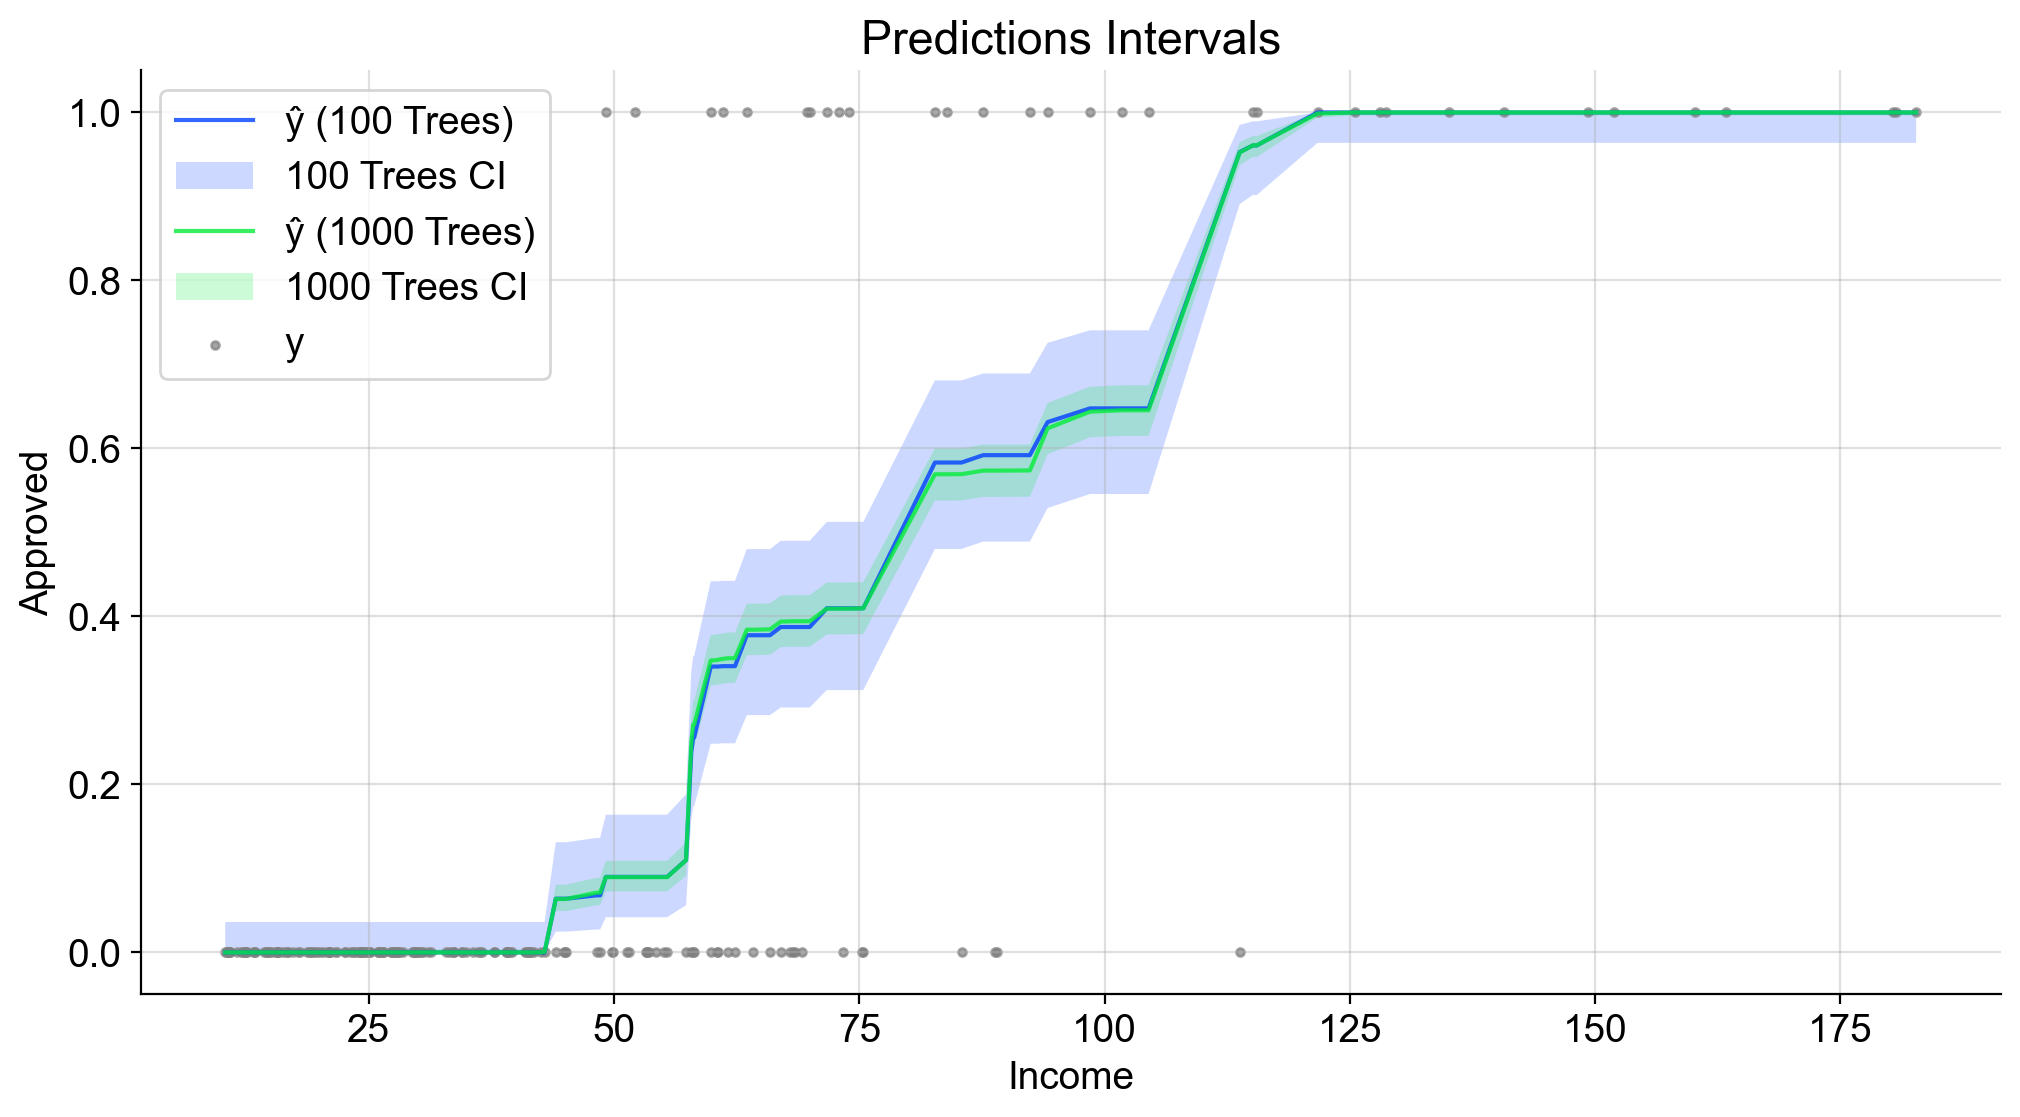

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from ISLP import load_data
%config InlineBackend.figure_format = 'retina'
 
# use style of plt
plt.style.use('seaborn-v0_8-bright')

Credit = load_data('Credit')
Credit['Approved'] = Credit['Rating'].apply(lambda x: 1 if x >= 500 else 0)

feature_name, target_name = 'Income', 'Approved'
X, y = Credit[feature_name].values.reshape(-1, 1), Credit[target_name].values

X_train, y_train = X[:200], y[:200]
X_test, y_test = X[200:], y[200:]

# Sort X_train for plotting
sort_indices = np.argsort(X_train.flatten())
X_train = X_train[sort_indices]
y_train = y_train[sort_indices]

sort_indices = np.argsort(X_test.flatten())
X_test = X_test[sort_indices]
y_test = y_test[sort_indices]

rf1 = RandomForestClassifier(
    max_depth=7,
    n_estimators=100,
    random_state=42,
    min_samples_leaf=1,
    monotonic_cst=[1]
)
rf1.fit(X_train, y_train)

rf2 = RandomForestClassifier(
    max_depth=7,
    n_estimators=1000,
    random_state=42,
    min_samples_leaf=1,
    monotonic_cst=[1]
)
rf2.fit(X_train, y_train)

# Visualization function
def visualize_intervals(X, y, methods, labels, title="Predictions Intervals"):
    """
    Plot confidence intervals for different methods.
    """
    plt.figure(figsize=(12, 6))
    
    for method, label in zip(methods, labels):
        mean_prediction, lower_bound, upper_bound = method
        # if label == "Percentile":
        plt.plot(X, mean_prediction, label=f"ŷ ({label})", alpha=0.8)
        plt.fill_between(X.flatten(), lower_bound, upper_bound, alpha=0.2, label=f"{label} CI")
    plt.scatter(X, y, color="grey", label="y", marker="o", s=8, alpha=0.7)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.title(title)
    plt.legend(ncols=1)
    plt.grid(which="both", alpha=0.4)
    plt.show()

# mean_binom_approx, lower_binom_approx, upper_binom_approx = binomial_confidence_interval_approx(rf1, X_test)
# mean_binom_approx2, lower_binom_approx2, upper_binom_approx2 = binomial_confidence_interval_approx(rf2, X_test)
mean_binom_exact, lower_binom_exact, upper_binom_exact = binomial_confidence_interval_exact(rf1, X_test)
mean_binom_exact2, lower_binom_exact2, upper_binom_exact2 = binomial_confidence_interval_exact(rf2, X_test)

visualize_intervals(
    X_test,
    y_test,
    methods=[
        # (mean_binom_approx, lower_binom_approx, upper_binom_approx),
        # (mean_binom_approx2, lower_binom_approx2, upper_binom_approx2),
        (mean_binom_exact, lower_binom_exact, upper_binom_exact),
        (mean_binom_exact2, lower_binom_exact2, upper_binom_exact2),
    ],
    labels=[
        "100 Trees",
        "1000 Trees",
    ],
)

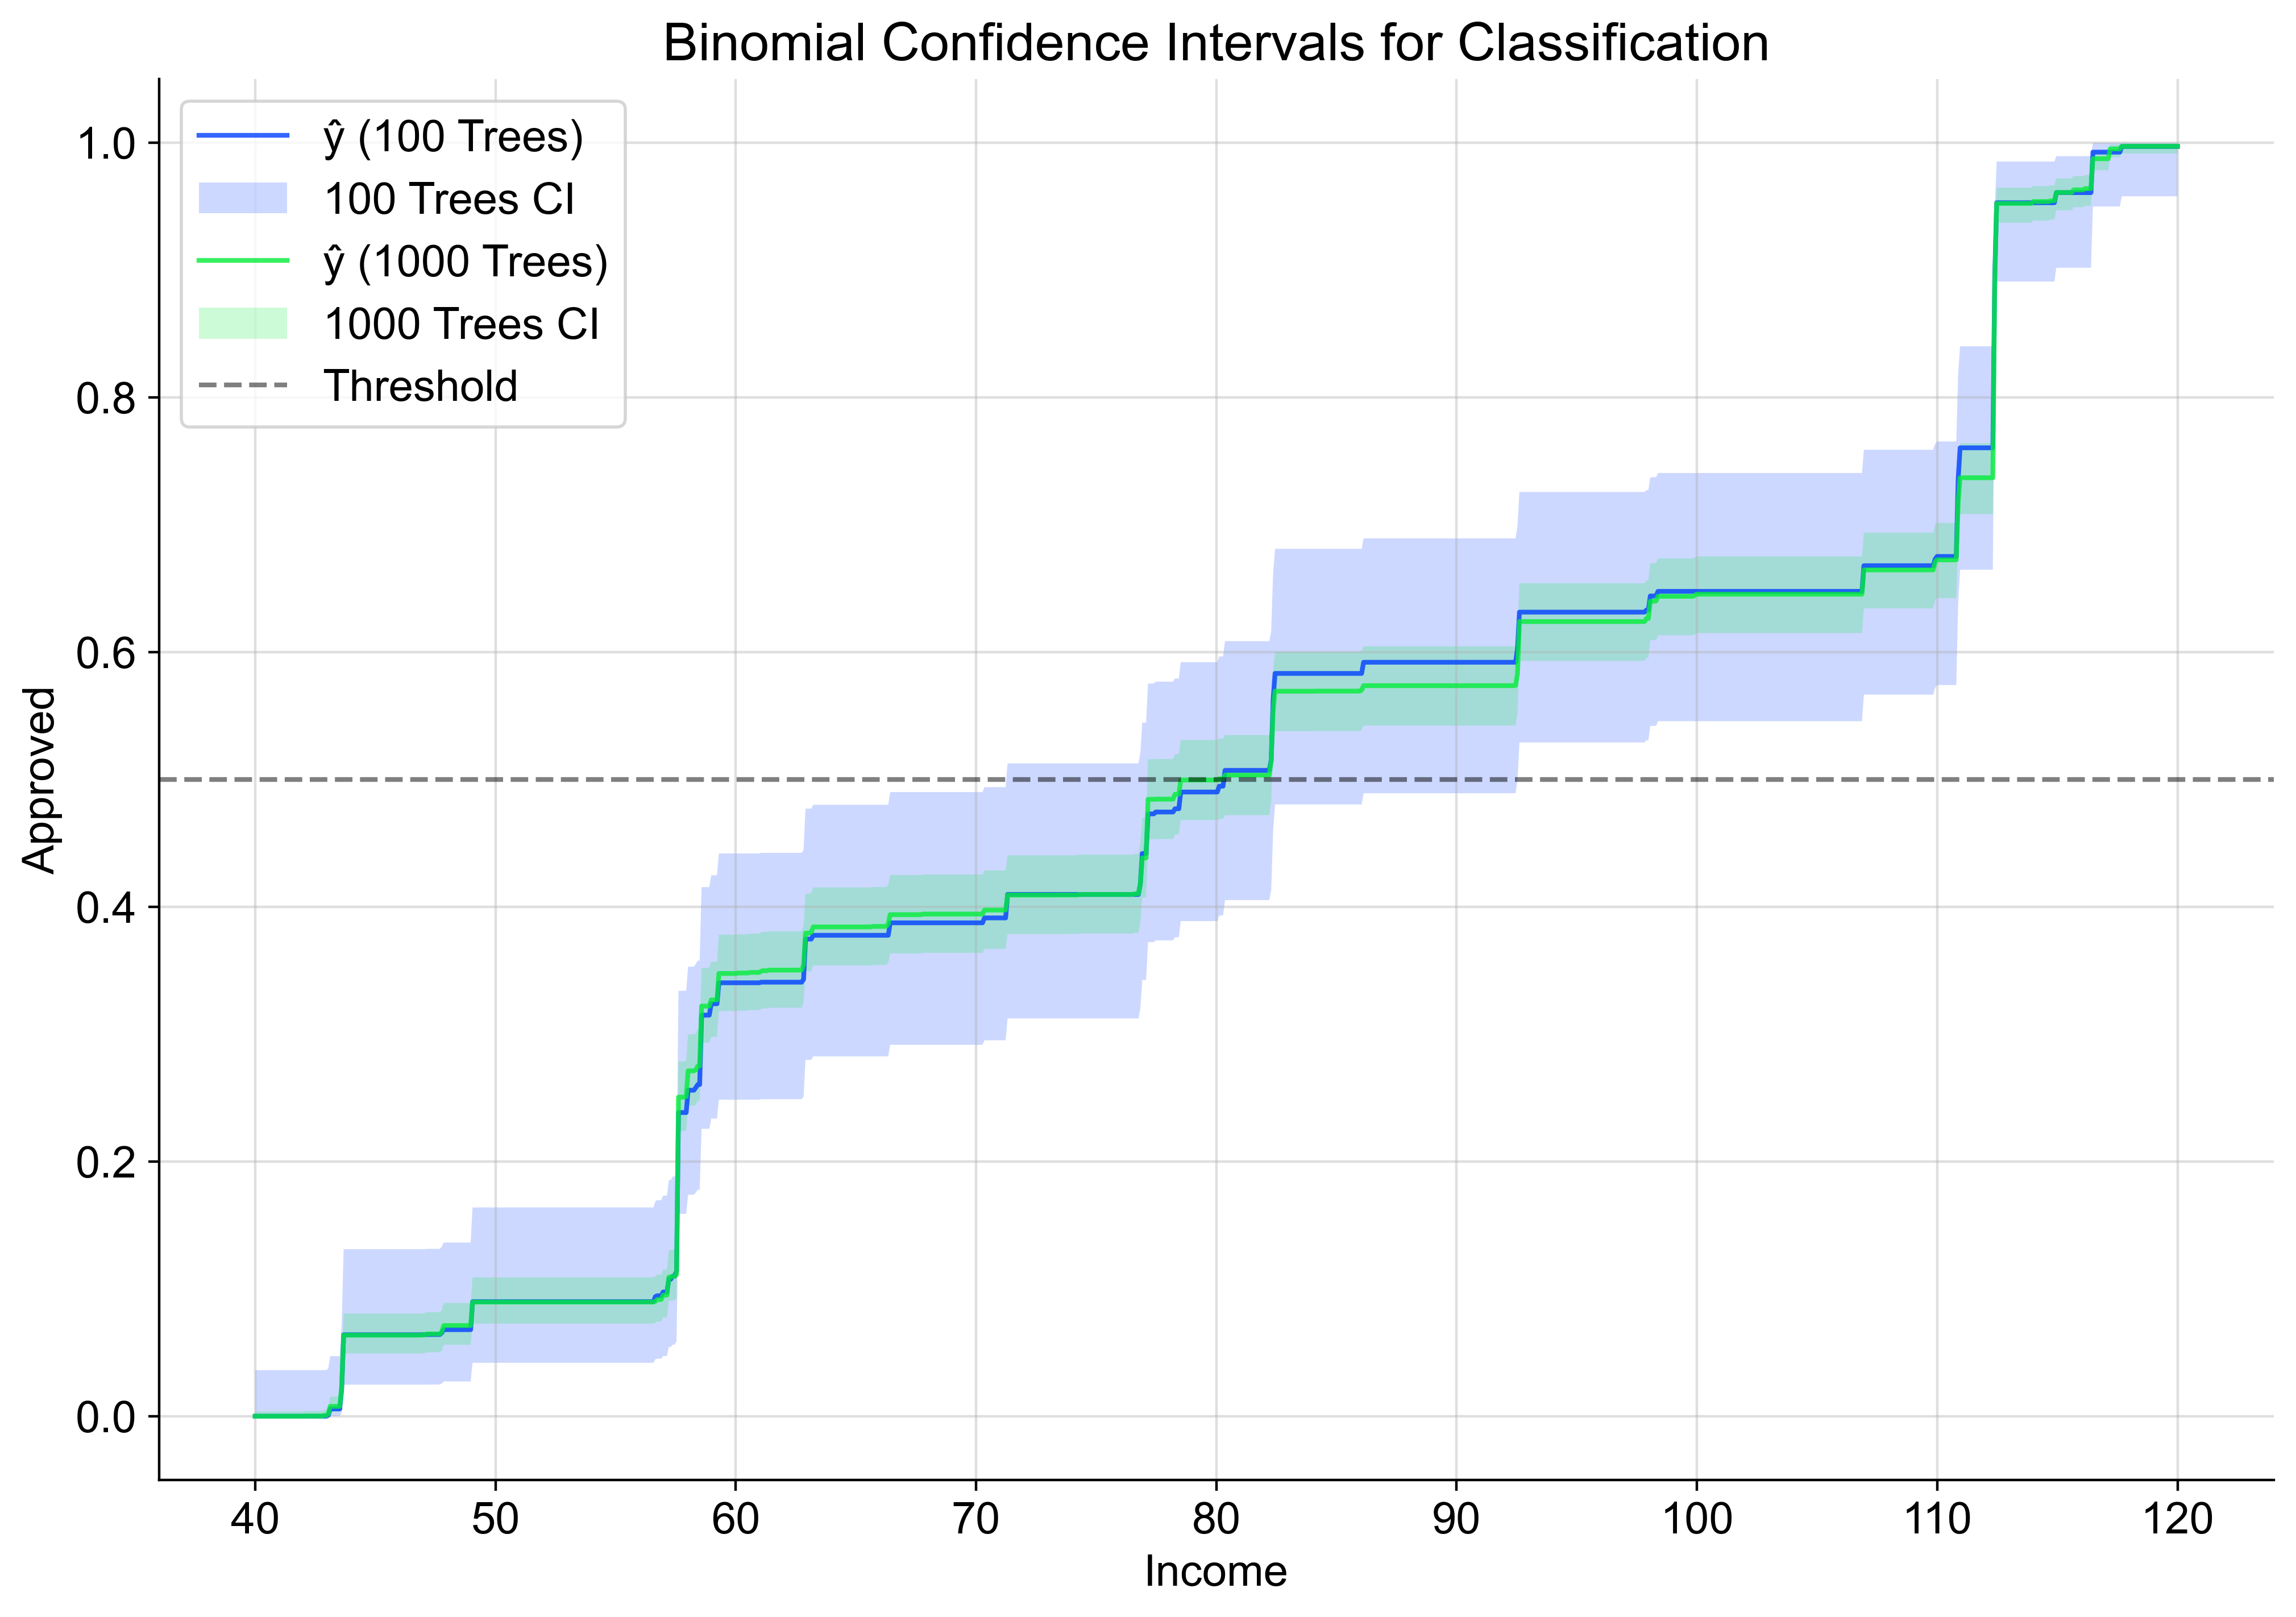

In [12]:
# Simulate a range of x values
X_simulated = np.linspace(40, 120, 1000).reshape(-1, 1)

# Set font to 14
plt.rcParams['font.size'] = 14

# Visualization function with simulated data
def visualize_intervals_simulated(X_sim, methods, labels, title="Binomial Confidence Intervals for Classification"):
    """
    Plot confidence intervals for a simulated range of X values.
    """
    plt.figure(figsize=(12, 8), dpi=200)
    
    for method, label in zip(methods, labels):
        mean_prediction, lower_bound, upper_bound = method
        plt.plot(X_sim, mean_prediction, label=f"ŷ ({label})", alpha=0.8)
        plt.fill_between(X_sim.flatten(), lower_bound, upper_bound, alpha=0.2, label=f"{label} CI")
    plt.axhline(0.5, color='black', linestyle="--", alpha=0.5, label="Threshold")
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.title(title)
    plt.legend()
    plt.grid(which="both", alpha=0.4)
    plt.show()

mean_binom_exact, lower_binom_exact, upper_binom_exact = binomial_confidence_interval_exact(rf1, X_simulated)
mean_binom_exact2, lower_binom_exact2, upper_binom_exact2 = binomial_confidence_interval_exact(rf2, X_simulated)

# Visualize comparisons with simulated range
visualize_intervals_simulated(
    X_simulated,
    methods=[
        (mean_binom_exact, lower_binom_exact, upper_binom_exact),
        (mean_binom_exact2, lower_binom_exact2, upper_binom_exact2),
    ],
    labels=[
        "100 Trees",
        "1000 Trees",
    ],
)

### Low Birth Weight Dataset (Logistic Regression and Random Forest)

Example from [Applied Logistic Regression](https://www.wiley.com/en-us/Applied+Logistic+Regression%2C+3rd+Edition-p-9780470582473) book.

We fit a monotonic random forest and construct Bernoulli confidence intervals for the predictions.

╭── Fisher Scoring Logistic Regression Fit ──╮
│                                            │
│         Total Fisher Scoring Iterations: 6 │
│         Log Likelihood: -111.6295          │
│         Beta 0 = intercept (bias): True    │
│                                            │
╰────────────────────────────────────────────╯

                         Fisher Scoring Logistic Regression Summary                          
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃        Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ intercept (bias) │ 0.8058   │ 0.8452     │ 0.9534         │ 0.3404  │ -0.8507  │ 2.4622   │
│              LWT │ -0.0152  │ 0.0064     │ -2.3641        │ 0.0181  │ -0.0278  │ -0.0026  │
│           RACE_2 │ 1.0811   │ 0.4881     │ 2.2151         │ 0.0268  │ 0.1245   │ 2.0376   │
│           RACE_3 │ 0.4806   │ 0.3567     │ 1.3475         │ 0.1778  │ -0.2185  │ 1.1797   │
└──────────────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘

None

Intercept       LWT    RACE_2    RACE_3
Intercept     0.7143 -0.005200  0.022600 -0.103500
LWT          -0.0052  0.000041 -0.000647  0.000360
RACE_2        0.0226 -0.000647  0.238195  0.053200
RACE_3       -0.1035  0.000360  0.053200  0.127216

-1.444
0.191
0.0768
0.2771
-1.987 -0.901
0.121 0.289


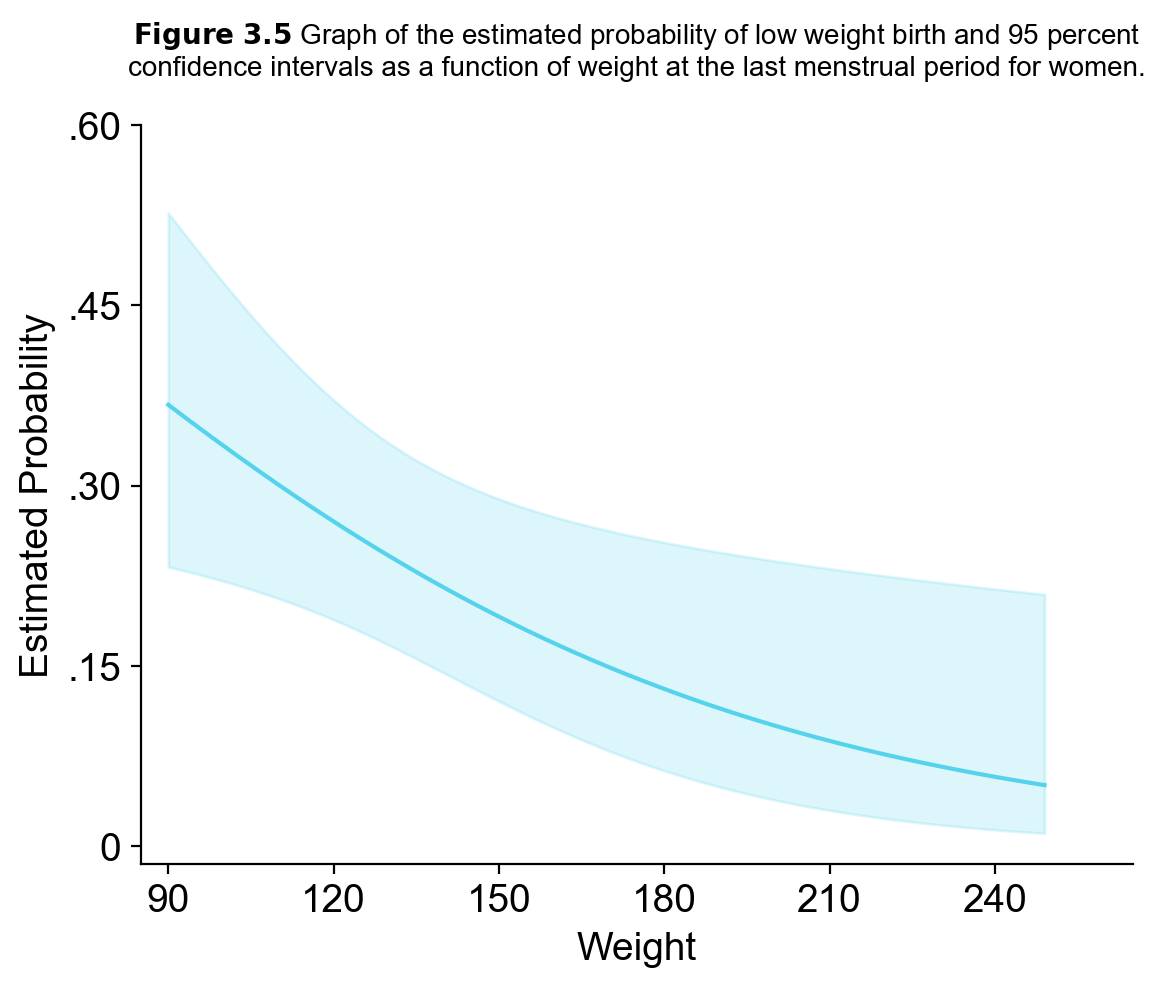

In [13]:
# 2.5 CONFIDENCE INTERVAL ESTIMATION
# PP 41-42.
import pandas as pd
from fisher_scoring import FisherScoringLogisticRegression
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
%config InlineBackend.figure_format = 'retina'

# Set font to Arial
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14

# Source: https://danstan.com/students/lowbirthweightdata.txt
dataset = pd.read_csv("/Users/deburky/Documents/python/python-ml-projects/focal-loss/lwt.csv")

features = ['LWT', 'RACE']
label = 'LOW'

race_dummies = (
    pd.get_dummies(dataset[features[1]], prefix='RACE')
    .astype(int)
)
X = pd.concat([dataset['LWT'], race_dummies], axis=1)
X.drop(columns='RACE_1', inplace=True)
y = dataset[label]

lr_model = FisherScoringLogisticRegression()
lr_model.fit(X, y)

display(lr_model.display_summary(style='dodger_blue1'))

# Create a covariance matrix of the estimated coefficients
information_matrix = lr_model.information_matrix['information'][-1]
information_matrix_inv = np.linalg.inv(information_matrix)

columns = ['Intercept'] + lr_model.feature_names
cov_matrix = pd.DataFrame(information_matrix_inv.round(6), columns=columns, index=columns)

# Adjust rounding per book example (P 42):
cov_matrix.iloc[0, 0] = cov_matrix.iloc[0, 0].round(4)
cov_matrix.iloc[2, 0] = cov_matrix.iloc[2, 0].round(4)
cov_matrix.iloc[0, 2] = cov_matrix.iloc[0, 2].round(4)
cov_matrix.iloc[3, 0] = cov_matrix.iloc[3, 0].round(4)
cov_matrix.iloc[0, 3] = cov_matrix.iloc[0, 3].round(4)
cov_matrix.iloc[1, 3] = cov_matrix.iloc[1, 3].round(5)
cov_matrix.iloc[3, 1] = cov_matrix.iloc[3, 1].round(5)
cov_matrix.iloc[1, 2] = cov_matrix.iloc[1, 2].round(6)
cov_matrix.iloc[2, 1] = cov_matrix.iloc[2, 1].round(6)
cov_matrix.iloc[0, 1] = cov_matrix.iloc[0, 1].round(4)
cov_matrix.iloc[1, 0] = cov_matrix.iloc[1, 0].round(4)
display(cov_matrix)

betas = lr_model.beta.flatten().round(3)  # Rounding in the example
x = np.array([1, 150.0, 0, 0])

g = np.dot(betas, x).round(4)
# g(LWT=150, RACE=White) = -1.44
# The estimated logit for a 150 pound white woman is:
print(g)

p = 1 / (1 + np.exp(-g))
# And the estimated logistic probability is:
print(p.round(3))
# The interpretation of the fitted value is that the estimated
# proportion of low birthweight babies among 150 pound white women is 0.191.

var = (x @ cov_matrix @ x.T).round(4)
# In order to estimate the variance of this estimated logit we need to obtain
# the estimated covariance matrix.
print(var)

# The standard error of the estimated logit is:
se = np.sqrt(var).round(4)
print(se)

# The 95 percent confidence interval for the estimated logit is:
print((g - 1.96 * se).round(3), (g + 1.96 * se).round(3))

# The associated confidence interval for the fitted value is (0.120, 0.289)
p_lower = 1 / (1 + np.exp(-(g - 1.96 * se)))
p_upper = 1 / (1 + np.exp(-(g + 1.96 * se)))
print(p_lower.round(3), p_upper.round(3))

results = {
    'threshold': [],
    'p': [],
    'p_lower': [],
    'p_upper': [],
}

# 3.9 INTERPRETATION OF THE FITTED VALUES
for i in range(90, 250, 1):
    x = np.array([1, i, 0, 0])
    g = np.dot(betas, x).round(4)
    p = 1 / (1 + np.exp(-g))
    var = (x @ cov_matrix @ x.T).round(4)
    se = np.sqrt(var).round(4)
    p_lower = 1 / (1 + np.exp(-(g - 1.96 * se)))
    p_upper = 1 / (1 + np.exp(-(g + 1.96 * se)))
    results['threshold'].append(i)
    results['p'].append(p)
    results['p_lower'].append(p_lower)
    results['p_upper'].append(p_upper)

plt.plot(
    pd.Series(results['threshold']),
    results['p'],
    color='#55d3ed'
)
plt.fill_between(
    pd.Series(results['threshold']),
    pd.Series(results['p_lower']),
    pd.Series(results['p_upper']),
    color='#55d3ed',
    alpha=0.2
)
plt.ylabel("Estimated Probability")
plt.xlabel("Weight")

plt.gca().xaxis.set_major_locator(MultipleLocator(30))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
plt.gca().set_xlim(85, 265)
plt.gca().set_yticks([0, 0.15, 0.3, 0.45, 0.6])
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}".lstrip('0') if y != 0 else '0'))

plt.title(
    # 0.5, -0.1,
    r"$\mathbf{Figure\ 3.5}$" 
    + " Graph of the estimated probability of low weight birth and 95 percent\n"
    "confidence intervals as a function of weight at the last menstrual period for women.",
    wrap=True,
    horizontalalignment='center',
    fontsize=10,
    y=1.05
)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

/Users/deburky/Library/Caches/pypoetry/virtualenvs/python-ml-projects-QQGQytla-py3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/deburky/Library/Caches/pypoetry/virtualenvs/python-ml-projects-QQGQytla-py3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/deburky/Library/Caches/pypoetry/virtualenvs/python-ml-projects-QQGQytla-py3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/deburky/Library/Caches/pypoetry/virtualenvs/python-ml-projects-QQGQytla-py3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fit

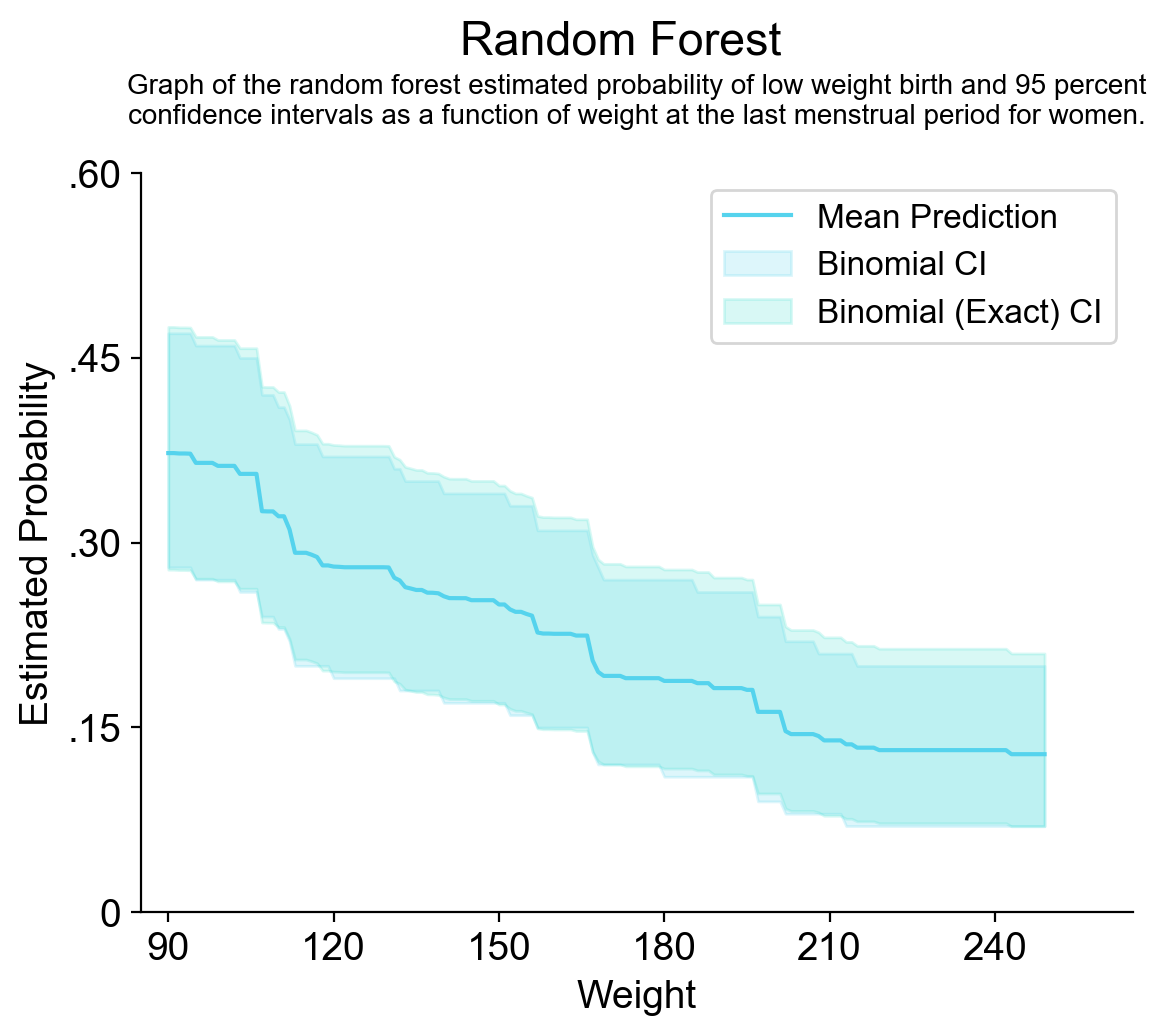

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import binom
from statsmodels.stats.proportion import proportion_confint

# Example feature and target preparation
np.random.seed(42)

# Train a Random Forest classifier
rf = RandomForestClassifier(
    random_state=42,
    monotonic_cst=[-1, 1, 1]
)
rf.fit(X, y)

# Define binomial confidence interval methods
def binomial_confidence_interval(model, X, confidence=0.95):
    """
    Compute exact binomial confidence intervals for classification.
    """
    # Get predictions from each tree (as probabilities)
    tree_predictions = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])
    
    # Calculate number of trees and successes
    n_trees = tree_predictions.shape[0]
    successes = tree_predictions.sum(axis=0)
    
    # Mean predictions and confidence bounds
    mean_prediction = successes / n_trees
    lower_bound = []
    upper_bound = []
    
    for s in successes:
        lb = binom.ppf((1 - confidence) / 2, n_trees, s / n_trees) / n_trees
        ub = binom.ppf((1 + confidence) / 2, n_trees, s / n_trees) / n_trees
        lower_bound.append(lb)
        upper_bound.append(ub)
    
    return mean_prediction, np.array(lower_bound), np.array(upper_bound)

def binomial_confidence_interval_exact(model, X, confidence=0.95, method='beta', alpha=None, **kwargs):
    """
    Compute confidence intervals for classification.
    """
    # Get predictions from each tree (as probabilities)
    tree_predictions = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])
    
    # Calculate number of trees and successes
    n_trees = tree_predictions.shape[0]
    successes = tree_predictions.sum(axis=0)
    
    # Mean predictions
    mean_prediction = successes / n_trees
    lower_bound = []
    upper_bound = []

    if alpha is None:
        alpha = 1 - confidence

    for s in successes:
        lb, ub = proportion_confint(s, n_trees, alpha=alpha, method=method, **kwargs)
        lower_bound.append(lb)
        upper_bound.append(ub)
    
    return mean_prediction, np.array(lower_bound), np.array(upper_bound)

predictions = []
bounds_binom = {'mean': [], 'lower': [], 'upper': []}
bounds_binom_exact = {'mean': [], 'lower': [], 'upper': []}

# 3.9 INTERPRETATION OF THE FITTED VALUES
for i in range(90, 250, 1):
    x = np.array([i, 0, 0]).reshape(1, -1)
    preds = rf.predict_proba(x)[:, 1][0]
    predictions.append(preds)
    # confidence interval
    mean_binom, lower_binom, upper_binom = binomial_confidence_interval(rf, x)
    mean_binom_exact, lower_binom_exact, upper_binom_exact = binomial_confidence_interval_exact(rf, x)
    bounds_binom['mean'].append(mean_binom[0])
    bounds_binom['lower'].append(lower_binom[0])
    bounds_binom['upper'].append(upper_binom[0])
    bounds_binom_exact['mean'].append(mean_binom_exact[0])
    bounds_binom_exact['lower'].append(lower_binom_exact[0])
    bounds_binom_exact['upper'].append(upper_binom_exact[0])
    
plt.plot(range(90, 250, 1), predictions, label="Mean Prediction", color='#55d3ed')
plt.fill_between(range(90, 250, 1), bounds_binom['lower'], bounds_binom['upper'], alpha=0.2, label="Binomial CI", color='#55d3ed')
plt.fill_between(range(90, 250, 1), bounds_binom_exact['lower'], bounds_binom_exact['upper'], alpha=0.2, label="Binomial (Exact) CI", color='turquoise')
plt.ylabel("Estimated Probability")
plt.xlabel("Weight")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().xaxis.set_major_locator(MultipleLocator(30))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
plt.gca().set_xlim(85, 265)
plt.gca().set_yticks([0, 0.15, 0.3, 0.45, 0.6])
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}".lstrip('0') if y != 0 else '0'))

plt.suptitle("Random Forest", y=1.04)
plt.title(
    # 0.5, -0.1,
    # make bold font Random Forest
    "Graph of the random forest estimated probability of low weight birth and 95 percent\n"
    "confidence intervals as a function of weight at the last menstrual period for women.",
    wrap=True,
    horizontalalignment='center',
    fontsize=10,
    y=1.05
)
plt.legend(fontsize=12)

In [15]:
display(pd.DataFrame({
    'threshold': range(90, 250, 1),
    'p': predictions,
    'p_lower_binom': bounds_binom['lower'],
    'p_upper_binom': bounds_binom['upper'],
    'p_lower_binom_exact': bounds_binom_exact['lower'],
    'p_upper_binom_exact': bounds_binom_exact['upper'],
}).query("threshold == 150"))

pd.DataFrame(results).query("threshold == 150")

threshold         p  p_lower_binom  p_upper_binom  p_lower_binom_exact  \
60        150  0.249827           0.17           0.34             0.168632   

    p_upper_binom_exact  
60             0.346366

threshold         p   p_lower   p_upper
60        150  0.190927  0.120562  0.288869